Soulier</br>
François</br>
SCIA Computer Vision - 2024

# TP 1 - Motion Estimation

## Setup

### Import des différentes bibliothèques

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
from matplotlib.patches import Polygon

### Import des images

In [2]:
def load_image(path: str) -> np.ndarray:
    """
    Load image from path and convert it to RGB
    
    :param path: path to image
    :return: image in RGB
    """
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def display_image(img: np.ndarray, title: str) -> None:
    """
    Display image with matplotlib

    :param img: image to display
    :param title: title of the image
    """
    plt.imshow(img, cmap="gray")
    plt.title(title)
    plt.axis('off')
    plt.show()

def display_images(img1: np.ndarray, img2: np.ndarray) -> None:
    """
    Display two images with matplotlib

    :param img1: first image to display
    :param img2: second image to display
    :param title1: title of the first image
    :param title2: title of the second image
    """
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    fig.suptitle('Images', fontsize=16)
    ax[0].imshow(img1, cmap="gray")
    ax[0].set_title("Frame 1")
    ax[0].axis('off')
    ax[1].imshow(img2, cmap="gray")
    ax[1].set_title("Frame 2")
    ax[1].axis('off')
    plt.show()

#### Chargement des images et affichage d'examples

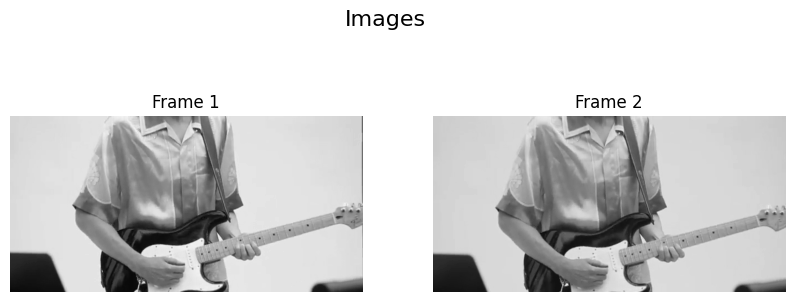

In [3]:
# Load two consecutive frames
frame1: np.ndarray = load_image("./images/Part1/LF000.jpg")
frame2: np.ndarray = load_image("./images/Part1/LF001.jpg")

# Display chosen frames
display_images(frame1, frame2)

## A - Pixel wise motion estimation

### Algorithme - Recherche exhaustive

Commencons par définir une fonction nous permettant de calculer localement la différence entre deux images, au voisinig d'un pixel donné, et sur une fenêtre donnée par les positions de ses coins.</br>
Nous allons utiliser l'erreur quadratique moyenne (MSE) pour le calcul de l'énergie $E_{dfd}$

In [4]:
def compute_ideal_motion_vectors(frame1: np.ndarray, frame2: np.ndarray, min_pos: tuple[int, int], max_pos: tuple[int, int], current_pixel: tuple[int, int]) -> tuple[np.ndarray]:
    """
    Compute the ideal motion vectors between two frames

    :param frame1: first frame
    :param frame2: second frame
    :param min_pos: minimum position of the current pixels window
    :param max_pos: maximum position of the current pixels window
    """
    min_x, min_y = min_pos
    max_x, max_y = max_pos
    i, j = current_pixel

    E = np.inf
    new_x = 0
    new_y = 0

    for k in range(min_x, max_x):
        stop_searching = False
        for l in range(min_y, max_y):
            # If a pixel is the same in both frames, we can stop the search
            if frame1[k, l] == frame2[i, j] and (k == i and l == j):
                new_x = 0
                new_y = 0
                stop_searching = True
                break
            
            # Compute the error between the two frames
            E_new = (frame2[k, l] - frame1[i, j]) ** 2
            # Compute the distance between the two pixels at position (k, l) and (i, j)
            diff_x = k - i
            diff_y = l - j
            
            # If the new error minimizes the previous one, we update the error and the motion vectors
            if E_new < E:
                E = E_new
                new_x = diff_x
                new_y = diff_y
            # If the new error is the same as the previous one, we keep the motion vectors that minimize the motion
            elif E_new == E and (diff_x < new_x or diff_y < new_y):
                new_x = diff_x
                new_y = diff_y

        if stop_searching:
            break
    
    return new_x, new_y

A présent, nous allons parcourir de manière naïve tous les pixels de l'image, et pour chacun d'entre eux, estimer le mouvement en calculant l'énergie $E_{dfd}$ pour chaque vecteur de mouvement possible. Nous allons ensuite choisir le vecteur de mouvement minimisant $E_{dfd}$.

In [5]:
def pixel_wise_motion_estimation(frame1: np.ndarray, frame2: np.ndarray, neighborhood: int = 5) -> tuple[np.ndarray]:
    """
    Compute the motion estimation between two frames using pixel-wise motion estimation

    :param frame1: first frame
    :param frame2: second frame
    :return: motion vectors
    """
    assert frame1.shape == frame2.shape, "Frames must have the same shape"

    frame_shape = frame1.shape
    # Normalize frames
    frame1 = frame1 / 255
    frame2 = frame2 / 255

    # Initialize motion vectors
    v_x = np.zeros(frame_shape, dtype='int')
    v_y = np.zeros(frame_shape, dtype='int')

    for i in range(frame_shape[0]):
        for j in range(frame_shape[1]):
            # Determine the neighborhood of the current pixel
            min_x = max(0, i - neighborhood)
            max_x = min(frame_shape[0], i + neighborhood)

            min_y = max(0, j - neighborhood)
            max_y = min(frame_shape[1], j + neighborhood)
            
            # Compute the motion vectors
            v_x[i, j], v_y[i, j] = compute_ideal_motion_vectors(frame1, frame2, (min_x, min_y), (max_x, max_y), (i, j))
    
    return v_x, v_y

# Compute motion estimation
motion_x, motion_y = pixel_wise_motion_estimation(frame1, frame2, neighborhood=3)

### Résultats
Nous pouvons à présent afficher les résultats de notre algorithme de recherche exhaustive. Afficher d'obtenir un résultat lisible, nous allons afficher uniquement un vecteur de mouvement sur 10.

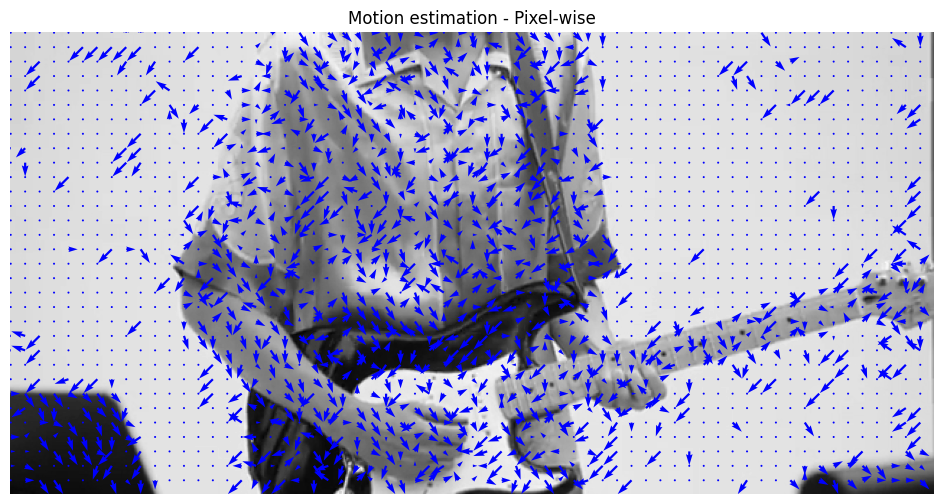

In [6]:
def display_motion_estimation(u: np.ndarray, v: np.ndarray, frame: np.ndarray, step: int = 5) -> None:
    """
    Display the motion estimation between two frames

    :param u: first frame
    :param v: second frame
    """
    # Pixel coordinates
    x_coords = np.arange(0, frame1.shape[1], step)
    y_coords = np.arange(0, frame1.shape[0], step)

    u = u[::step, ::step]
    v = v[::step, ::step]

    _, ax = plt.subplots(1, 1, figsize=(15, 6))
    ax.imshow(frame, cmap='gray')
    ax.set_axis_off()
    ax.set_title('Motion estimation - Pixel-wise')
    
    ax.quiver(x_coords, y_coords, u, v, scale=200, color='blue')
    plt.show()

# Display motion estimation
display_motion_estimation(motion_x, motion_y, frame1, step=10)

## B - Block Matching Algorithm (BMA)

Avant d'implémenter l'algorithme de Block Matching, nous allons définir une fonction nous permettant de calculer la différence moyenne entre deux blocs de pixels. Comme pour la méthode pixel-wise, nous allons utiliser l'erreur quadratique moyenne (MSE) pour le calcul de l'énergie $E_{dfd}$

In [7]:
def compute_ideal_motion_vectors_BMA(frame1: np.ndarray, frame2: np.ndarray, block_size: int, window_size: int, current_block: np.ndarray, current_pixel: tuple[int, int]) -> tuple[int, int]:
    """
    Compute the ideal motion vectors between two frames
    :param frame1: first frame
    :param frame2: second frame
    :param block_size: size of a block
    :param window_size: size of the window
    :param current_block: current block
    :param current_pixel: current pixel
    """
    i, j = current_pixel
    E = np.inf
    new_x = 0
    new_y = 0

    # Search in the window
    for k in range(i - window_size, i + window_size):
        stop_searching = False
        for l in range(j - window_size, j + window_size):
            # If a pixel is the same in both frames, we can stop the search
            if k == i and l == j and frame1[i, j] == frame2[k, l]:
                new_x = 0
                new_y = 0
                stop_searching = True
                break
    
            # Define a new block for the current iteration
            new_block = frame2[k:k+block_size, l:l+block_size]

            # If the new block is not the same size as the current block, we skip it
            if new_block.shape != current_block.shape:
                continue

            # Compute the error between the two blocks
            E_new = np.sum(np.abs((new_block - current_block)) ** 2)

            # Compute the distance between the two pixels at position (k, l) and (i, j)
            diff_x = k - i
            diff_y = l - j

            # If the new error minimizes the previous one, we update the error and the motion vectors
            if E_new < E:
                E = E_new
                new_x = diff_x
                new_y = diff_y
            # If the new error is the same as the previous one, we keep the motion vectors that minimize the motion
            elif E_new == E and (diff_x < new_x or diff_y < new_y):
                new_x = diff_x
                new_y = diff_y
                
        if stop_searching:
            break

    return new_x, new_y

Ainsi nous pouvons implémenter l'algorithme de Block Matching.

In [8]:
def BMA(frame1: np.ndarray , frame2: np.ndarray, block_size: int = 16, window_size: int = 7) -> tuple[np.ndarray]:
    """
    Compute the motion estimation between two frames using the block matching algorithm

    :param frame1: first frame
    :param frame2: second frame
    :return: motion vectors
    """
    assert frame1.shape == frame2.shape, "Frames must have the same shape"

    frame_shape = frame1.shape
    # Normalize frames
    frame1 = frame1 / 255
    frame2 = frame2 / 255

    # Initialize block coordinates
    r_i = range(0, frame_shape[0], block_size)
    r_j = range(0, frame_shape[1], block_size)

    # Get the number of blocks by row and column
    l_r_i = len(r_i)
    l_r_j = len(r_j)

    # Initialize motion vectors
    v_x = np.zeros((l_r_i, l_r_j), dtype='int')
    v_y = np.zeros((l_r_i, l_r_j), dtype='int')

    for i in r_i:
        for j in r_j:
            # Get the current block
            current_block = frame1[i:i+block_size, j:j+block_size]

            # Compute the motion vectors for the current block
            motion_vectors = compute_ideal_motion_vectors_BMA(frame1, frame2, block_size, window_size, current_block, (i, j))
            v_x[i // block_size, j // block_size] = motion_vectors[0]
            v_y[i // block_size, j // block_size] = motion_vectors[1]

    return v_x, v_y

Affichons à présent les résultats de notre algorithme de Block Matching en affichant les vecteurs de mouvement.

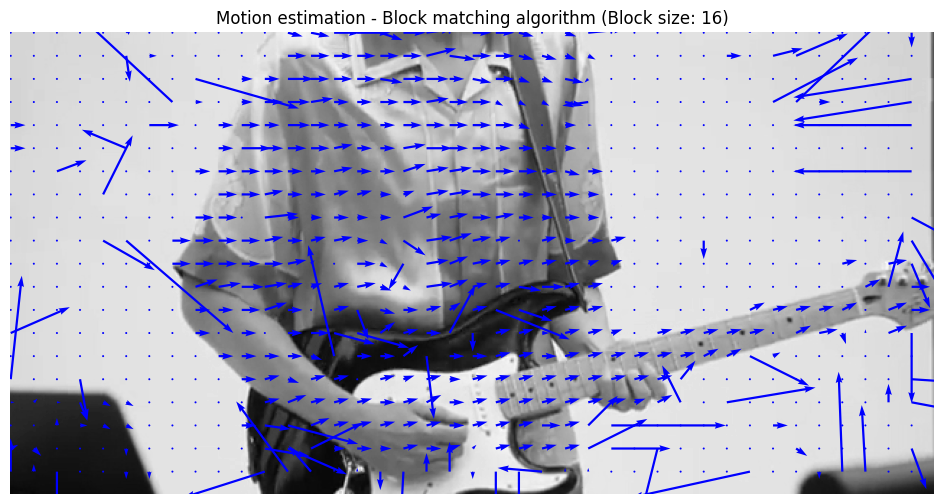

In [9]:
def BMA_display(frame1: np.ndarray, frame2: np.ndarray, block_size: int = 16, window_size: int = 10) -> None:
    v_x , v_y = BMA(frame1, frame2, block_size=block_size, window_size=window_size)

    x_coords = np.arange(0, frame1.shape[1], block_size)
    y_coords = np.arange(0, frame1.shape[0], block_size)

    _, ax = plt.subplots(1, 1, figsize=(15, 6))
    ax.imshow(frame1, cmap='gray')
    ax.set_axis_off()
    ax.set_title(f'Motion estimation - Block matching algorithm (Block size: {block_size})')

    ax.quiver(x_coords, y_coords, v_x, v_y, scale=250, color='blue')
    plt.show()

BMA_display(frame1, frame2, block_size=16, window_size=32)

On peut observer certaines irrégularités dans les vecteurs de mouvement par blocs. Cependant, au niveau du guitariste, on peut observer que les vecteurs de mouvement sont bien plus réguliers et localement uniformes que la méthode pixel-wise.

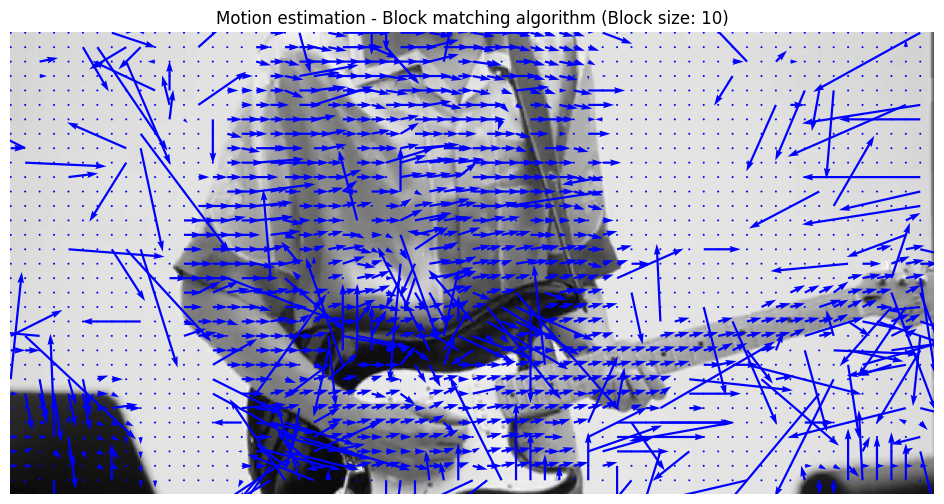

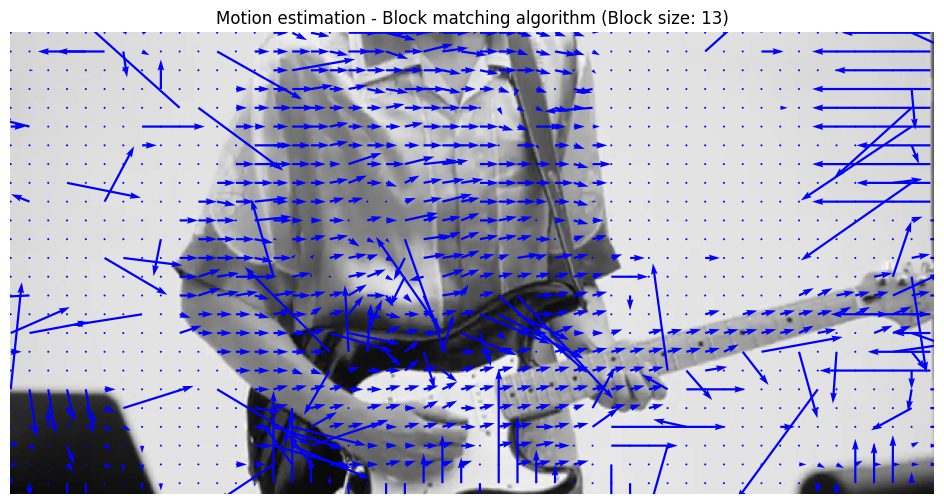

In [10]:
for block_size in [10, 13]:
    BMA_display(frame1, frame2, block_size=block_size, window_size=32)

En prenant des tailles de blocks plus petits (10 et 13), on peut observer que les vecteurs de mouvement sont plus irréguliers. On perd donc en précision, et donc en uniformité. Ainsi, il est important de choisir une taille de block adaptée au images que l'on souhaite traiter. En effet, si les blocks sont trop petits, on perd en régularité. A l'inverse, si les blocks sont trop grands, on perd en précision.

## D - Node based algorithm

Chargons dans un premier temps les images fournies.

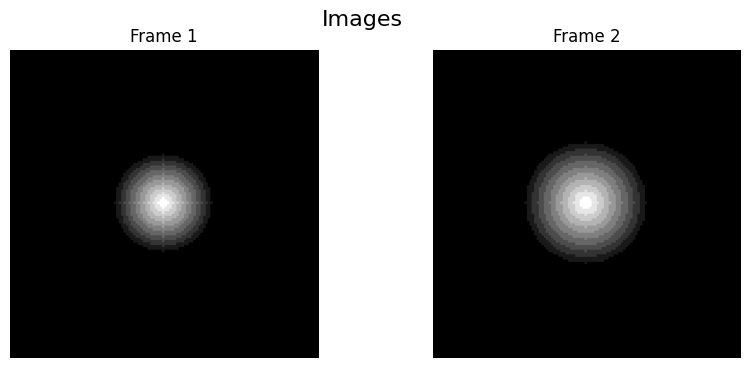

In [11]:
pic1: np.ndarray = load_image("./images/Part2/1.png")
pic2: np.ndarray = load_image("./images/Part2/2.png")

# Display provided frames
display_images(pic1, pic2)

On peut dès à présent se donner quelques hyperparamètres.

In [12]:
IMG_HEIGHT = pic1.shape[0]
IMG_WIDTH = pic1.shape[1]
BLOCK_SIZE = ((IMG_HEIGHT + IMG_HEIGHT) // 2) // 4
LEARNING_RATE = 0.001
EPOCHS = 10

print(f'Block size: {BLOCK_SIZE}')

Block size: 150


L'étape suivante est de déterminer les positions des blocs initiaux dans l'image de référence : `pic1`

In [13]:
def get_blocks_positions(img: np.ndarray, block_size: int) -> np.ndarray:
    """
    Compute the positions of the blocks in the image

    :param img: image
    :param block_size: size of the blocks
    :return: blocks positions
    """
    blocks: list = []

    # Determine blocks positions
    for j in range(0, img.shape[0], block_size):
        for i in range(0, img.shape[1], block_size):
            block: list = []
            block.append([i, j])
            block.append([i, j + block_size])
            block.append([i + block_size, j + block_size])
            block.append([i + block_size, j])
            
            # Add block to list
            blocks.append(block)
    
    return np.array(blocks)

blocks = get_blocks_positions(pic1, BLOCK_SIZE)
print(f'Number of blocks: {blocks.shape[0]}')

Number of blocks: 16


Vérifions que les blocs sont bien placés en les affichant sur l'image de référence.

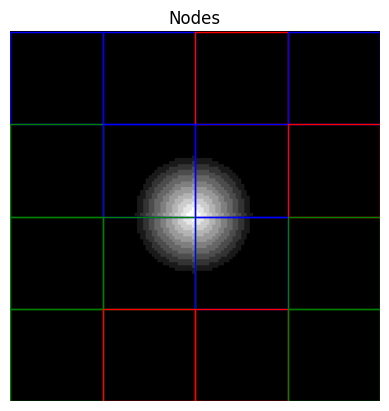

In [14]:
def display_nodes(img: np.ndarray, nodes: np.ndarray) -> None:
    """
    Display the nodes in the image

    :param img: image
    :param nodes: nodes
    """
    _, ax = plt.subplots()
    ax.imshow(img, cmap='gray')
    ax.set_axis_off()
    ax.set_title('Nodes')

    for node in nodes:
        ax.add_patch(
            Polygon(node, linewidth=1, edgecolor=np.random.choice(['red', 'green', 'blue']), facecolor='none')
        )
    
    plt.show()

display_nodes(pic1, blocks)

Avant de commencer l'algorithme, il faut définir les polynômes d'interpolation $\Phi_k$.

In [15]:
def phi(pos: tuple[int, int], pos_min: tuple[int, int], pos_max: tuple[int, int]) -> list[float]:
    """
    Compute the phi functions (interpolation kernel)
    :param pos: position
    :param pos_min: minimum position
    :param pos_max: maximum position
    :return: phi functions (interpolation kernel)
    """
    x, y = pos
    
    x_min, y_min = pos_min
    x_max, y_max= pos_max

    cst = ((x_max - x_min) * (y_max - y_min))

    # Compute phi functions in regards to
    # the polynomials formulas
    phi_1 = (x_max - x) * (y_max - y) / cst
    phi_2 = (x - x_min) * (y_max - y) / cst
    phi_3 = (x_max - x) * (y - y_min) / cst
    phi_4 = (x - x_min) * (y - y_min) / cst

    return [phi_1, phi_2, phi_3, phi_4]

Nous pouvons maintenant définir une fonction d'énergie $E_{dfd}$ (Displaced Frame Difference).

In [16]:
def displaced_frame_difference(d_b: np.ndarray, frame1: np.ndarray, frame2: np.ndarray, block_positions: np.ndarray) -> float:
    """
    Compute the displaced frame difference energy between two frames

    :param d: motion vector
    :param frame1: first frame
    :param frame2: second frame
    :param block: block
    :return: displaced frame difference
    """

    # Get the min and max positions of the blocks
    x_min, x_max = block_positions[:, 0].min(), block_positions[:, 0].max()
    y_min, y_max= block_positions[:, 1].min(), block_positions[:, 1].max()
   
    E_dfd: float = 0
    
    # Iterate over every pixel in the block
    for x in range(x_min, x_max):
        for y in range(y_min, y_max):
            d = d_b.copy()
            # Compute the interpolation kernel
            phi_tup = phi((x, y), (x_min, y_min), (x_max, y_max))

            for k in range(d_b.shape[0]):
                d += phi_tup[k] * d_b[k]
            
            d = d.sum(axis=0)
            # Compute the new position
            new_pos = np.array([x, y]) + d.astype(int)
            # Clip the new position to the frame size
            new_pos = np.clip(new_pos, 0, frame1.shape[0] - 1)
            
            # Compute the displaced frame difference
            E_dfd += abs(frame2[new_pos[0], new_pos[1]] - frame1[x, y])

    return E_dfd

<u>Remarques :</u>
* Nous avons choisi de ne pas prendre en compte les pixels qui ne sont pas dans l'image de référence. Cela permet de ne pas avoir à gérer les cas où le bloc est en dehors de l'image.
* Pour la fonction $E_{dfd}$, nous utilisons ici la différence moyenne absolue. Par expérimentation, les résultats avec l'erreur quadratique moyenne étaient bien moins bons.

Maintenant que nous avons une fonction nous permettant de calculer l'enéregie / erreur de l'estimation de mouvement, nous devons définir une fonction nous permettant de réduire, et ainsi minimiser cette énergie. Dans notre cas, nous allons utiliser l'algorithme de descente de gradient, afin de déterminer les meilleurs paramètres $\vec{d_{k}}$.

In [17]:
def compute_block_displacement(frame1: np.ndarray, frame2: np.ndarray, block: np.ndarray, d: np.ndarray, learning_rate: float, epochs: int) -> np.ndarray:
    """
    Compute the displaced blocks
    :param frame1: first frame
    :param frame2: second frame
    :param blocks: blocks
    :param d: motion vector
    :return: displaced blocks
    """
    # Iterate over the number of epochs
    for _ in range(epochs):
        # Compute the displaced frame difference
        E_dfd = displaced_frame_difference(d, frame1, frame2, block)

        # Initialize the gradient
        gradient = np.zeros((4, 2))
        for i in range(gradient.shape[0]):
            for j in range(gradient.shape[1]):
                diff_d = d.copy()
                # Compute an approximation of the partial derivative of the displaced frame difference
                # according to the d[i, j] parameter
                diff_d[i, j] += 1
                diff_E_dfd = displaced_frame_difference(diff_d, frame1, frame2, block)
                # Compute the gradient
                gradient[i, j] = (diff_E_dfd - E_dfd)

        # Update the motion parameters according to the gradient and the learning rate
        d = d - learning_rate * gradient

        # Stop the algorithm if overall update is too small (the algorithm converged)
        # Else with continue the gradient descent
        if np.abs(gradient).mean() * learning_rate < 0.1:
            break

    return d

Enfin, nous pouvons calculer les nouveaux blocs, en détermiant leurs déplacements.

In [18]:
d_new = np.zeros(blocks.shape)
for i in range(blocks.shape[0]):
    d_new[i] = compute_block_displacement(
        frame1=pic1,
        frame2=pic2,
        block=blocks[i],
        d=d_new[i],
        learning_rate=LEARNING_RATE,
        epochs=EPOCHS
    )
new_blocks = blocks + d_new

/var/folders/6w/l_4p050n0js7pwx4t7cb7k5r0000gn/T/ipykernel_32431/2583763048.py:34: RuntimeWarning: overflow encountered in ubyte_scalars
  E_dfd += abs(frame2[new_pos[0], new_pos[1]] - frame1[x, y])


Affichons le résultat ces nouveaux blocs sur l'image de référence.

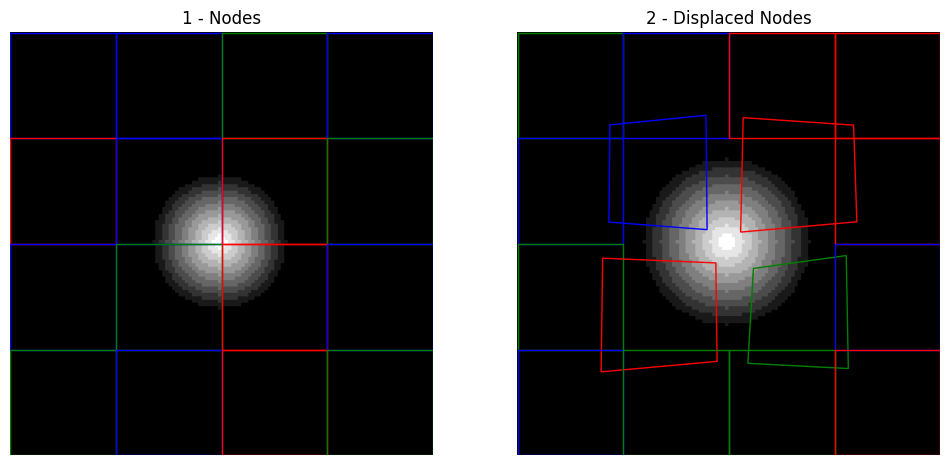

In [19]:
def display_nodes_difference(img1: np.ndarray, img2: np.ndarray, nodes1: np.ndarray, nodes2: np.ndarray) -> None:
    """
    Display the nodes in the image

    :param img1: First image
    :param img2: Second image
    :param nodes1: nodes of the first image
    :param nodes2: nodes of the second image
    """
    _, ax = plt.subplots(1, 2, figsize=(12, 12))
    ax[0].imshow(img1, cmap='gray')
    ax[0].set_axis_off()
    ax[0].set_title('1 - Nodes')

    ax[1].imshow(img2, cmap='gray')
    ax[1].set_axis_off()
    ax[1].set_title('2 - Displaced Nodes')

    for node in nodes1:
        ax[0].add_patch(
            Polygon(node, linewidth=1, edgecolor=np.random.choice(['red', 'green', 'blue']), facecolor='none')
        )
    
    for node in nodes2:
        ax[1].add_patch(
            Polygon(node, linewidth=1, edgecolor=np.random.choice(['red', 'green', 'blue']), facecolor='none')
        )
    
    plt.show()

display_nodes_difference(pic1, pic2, blocks, new_blocks)

Comme nous pouvons le constater, **seuls** les noeuds des blocks contenant uniquement des pixels noirs **dans les deux images** n'ont pas bougé. En effet, les pixels ne bougeant pas entre deux images, alors l'énegie $E_{dfd}$ est nulle (donc minimale).</br>
En revanche, le motif central s'est agrandi, provoquant alors un mouvement des noeuds des blocs concernés (les blocs centraux). On remarque aussi que des pixels sont passés de noirs à blancs / gris, provoquant là aussi mouvement des noeuds.

On observe par ailleurs que la méthode par noeuds est beaucoup plus précise et stable que la méthode par blocs (ou par pixels). En revanche, le temps de calcul est bien plus long pour la méthode par noeuds.